
 This notebook summarises:
1) Distribution of final predictions on the test set
2) Holdout Model - Model Correlation Heatmap
3) Holdout Daily IC Distribution (Model-by-Box Line)
4) Holdout IC Time Series (eq / grid / ridge-clip overlay, 5-day moving average)



Cell 1: Imports & global style

In [1]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
if Path.cwd().name == "notebooks" and (Path.cwd().parent / "reports").exists(): os.chdir(Path.cwd().parent) 
print(f"[INFO] ROOT={Path.cwd()}")

# --- Matplotlib minimal style ---
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 140,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def tight():
    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

[INFO] ROOT=d:\Sam\Fintech\ds_project\baseline



Cell 2 — Path and weight

In [2]:
ROOT = Path(".").resolve()
# ==== Paths (Can be changed to your actual path) ====
SUB_EQ9             = ROOT / "submissions/pred_final_global_eq9.parquet"                  
SUB_GRID            = ROOT /"submissions/pred_final_global_v6_ridge.parquet"            
SUB_RIDGE_CLIP      = ROOT /"submissions/pred_final_global_v6_ridge_clip.parquet"     
HOLDOUT_DATES       = ROOT /"reports/holdout_dates.parquet"  # generate by 09e_build_holdout_dates.py


# Holdout single-model prediction (used in Figure 2~Figure 5)
VALPREDS = {
    "MLP_7"  : ROOT /"reports/infer_global_v2_mlp_ae/valpred_global_mlp_seed7.parquet",
    "MLP_77" : ROOT /"reports/infer_global_v2_mlp_ae/valpred_global_mlp_seed77.parquet",
    "MLP_770": ROOT /"reports/infer_global_v2_mlp_ae/valpred_global_mlp_seed770.parquet",
    "XGB_7"  : ROOT /"reports/infer_global_v2_xgb/valpred_global_xgb_seed7.parquet",
    "XGB_77" : ROOT /"reports/infer_global_v2_xgb/valpred_global_xgb_seed77.parquet",
    "XGB_770": ROOT /"reports/infer_global_v2_xgb/valpred_global_xgb_seed770.parquet",
    "LGB_7"  : ROOT /"reports/infer_global_v2_lgbm_ae_fullholdout/valpred_global_lgb_seed7.parquet",
    "LGB_77" : ROOT /"reports/infer_global_v2_lgbm_ae_fullholdout/valpred_global_lgb_seed77.parquet",
    "LGB_770": ROOT /"reports/infer_global_v2_lgbm_ae_fullholdout/valpred_global_lgb_seed770.parquet",
}

# ==== 9 model weights from previous searches (aligned to VALPREDS order) ====
# grid(The sum of weights is 1)
W_GRID = np.array([0.23066458, 0.20713449, 0.22994716, 0.02494552, 0.03330491,
                   0.00508047, 0.03408271, 0.22450068, 0.01033948], dtype=float)

# ridge-clip
W_RIDGE_CLIP = np.array([0.09737, 0.0, 0.42492, 0.0, 0.04573,
                         0.0, 0.000187, 0.43180, 0.0], dtype=float)

def read_parquet_or_none(p: Path):
    if not p.exists():
        print(f"[WARN] missing: {p}")
        return None
    return pd.read_parquet(p)

print(f"[INFO] ROOT={ROOT}")

[INFO] ROOT=D:\Sam\Fintech\ds_project\baseline



Cell 3 - Tool Functions (Read/IC/Monthly Aggregation)

In [3]:
# 占位，避免后续 NameError
ic_all = None
names  = []
P      = None  # 预测矩阵 (n_days, n_models)

dts = read_parquet_or_none(HOLDOUT_DATES)
if dts is None:
    print("[WARN] holdout_dates not found; skip subsequent holdout plots.")
else:
    holdout_dates = dts["date"].values
    ic_tbl = []
    cols   = []
    ref_y  = None

    for name, path in VALPREDS.items():
        df = read_parquet_or_none(path)
        if df is None: 
            continue
        y = df["y"].values.astype(np.float32)
        p = df["pred"].values.astype(np.float32)
        m = min(len(y), len(p), len(holdout_dates))
        # 统一用同一份 y（来自第一个可用模型）
        if ref_y is None:
            ref_y = y[:m]
        # 逐日截面相关 → daily IC
        tmp = pd.DataFrame({"y": ref_y[:m], "p": p[:m], "date": holdout_dates[:m]})
        tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()
        out = []
        for d, g in tmp.groupby("date", sort=True):
            if g["p"].nunique() >= 2 and g["y"].nunique() >= 2:
                r = np.corrcoef(g["p"].values, g["y"].values)[0,1]
                out.append((d, r))
        ic = pd.DataFrame(out, columns=["date","ic"])
        ic["model"] = name
        ic_tbl.append(ic)

        cols.append((name, p[:m]))

    if ic_tbl:
        ic_all = pd.concat(ic_tbl, ignore_index=True)
        names  = [x[0] for x in cols]
        P      = np.column_stack([x[1] for x in cols])
        print(f"[INFO] holdout IC rows: {len(ic_all)}  models: {len(names)}")


[INFO] holdout IC rows: 261  models: 9



Cell 4 — Test final prediction distribution

count    538150.000000
mean         -0.030039
std           0.145252
min          -0.626490
25%          -0.117083
50%          -0.039531
75%           0.048249
max           0.562362
Name: pred, dtype: float64


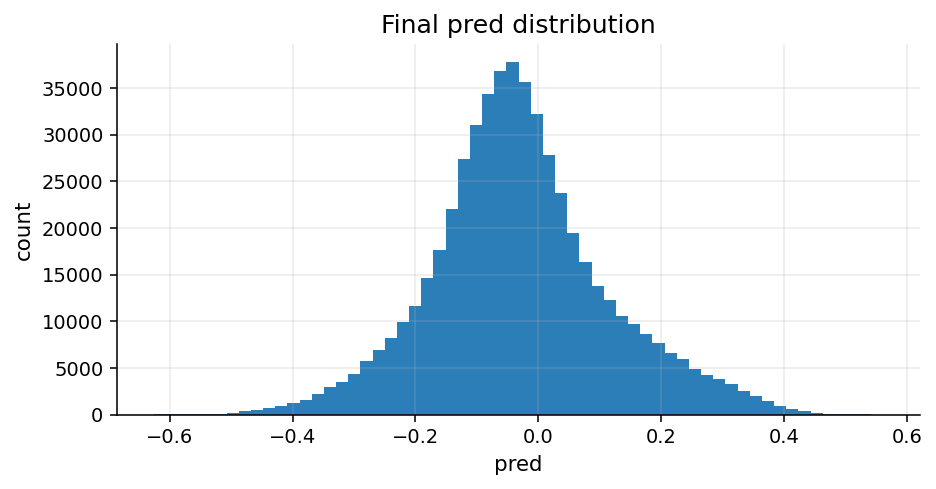

In [4]:
final_sub = None
for cand in [SUB_RIDGE_CLIP, SUB_GRID, SUB_EQ9]:
    if cand.exists():
        final_sub = cand
        break

if final_sub is None:
    print("[WARN] no submission parquet found, skip Fig.1")
else:
    sub = pd.read_parquet(final_sub)
    print(sub["pred"].describe())  # 看范围/偏度/是否异常截断
    plt.figure(figsize=(6.8, 3.6))
    plt.hist(sub["pred"].values, bins=60, alpha=0.95, edgecolor="none")
    plt.title("Final pred distribution")
    plt.xlabel("pred"); plt.ylabel("count")
    tight(); plt.show()

Examine the range and distributional characteristics of the final submission (e.g., symmetry, heavy tails, extreme values) to avoid anomalous truncation or scale mismatch.

Cell 5 —holdout (loading valpreds with date)

C:\Users\13004\AppData\Local\Temp\ipykernel_50368\1365201298.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, vert=True, patch_artist=True,


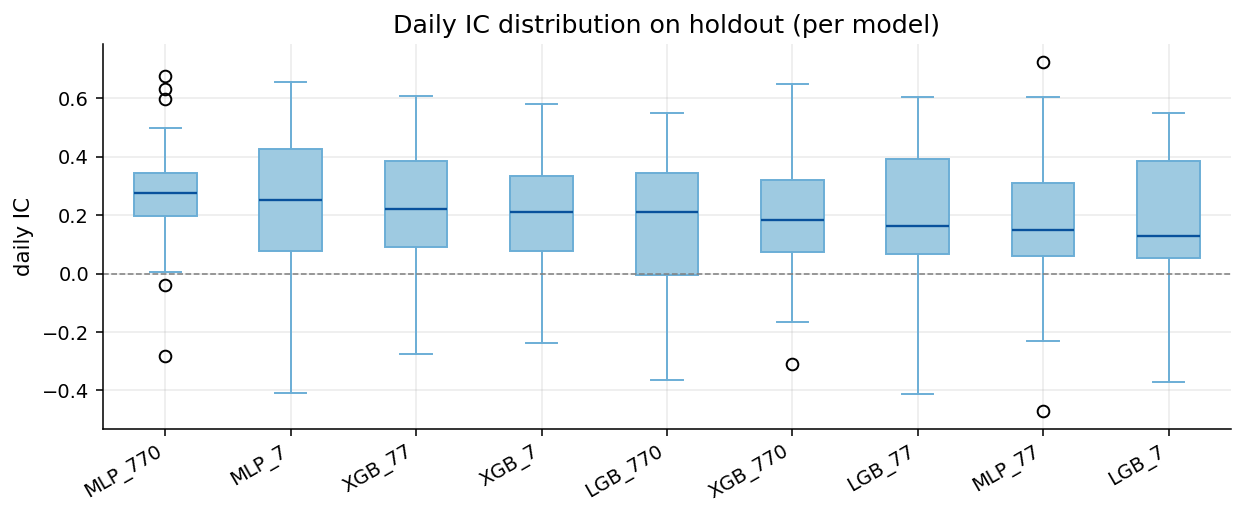

In [5]:
if ic_all is not None and not ic_all.empty:
    order = (ic_all.groupby("model")["ic"].median()
             .sort_values(ascending=False)).index.tolist()
    data = [ic_all.loc[ic_all["model"]==m, "ic"].values for m in order]
    plt.figure(figsize=(9.0, 3.8))
    plt.boxplot(data, labels=order, vert=True, patch_artist=True,
                boxprops=dict(facecolor="#9ecae1", edgecolor="#6baed6"),
                medianprops=dict(color="#08519c", linewidth=1.2),
                whiskerprops=dict(color="#6baed6"),
                capprops=dict(color="#6baed6"))
    plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
    plt.title("Daily IC distribution on holdout (per model)")
    plt.ylabel("daily IC")
    plt.xticks(rotation=30, ha="right")
    tight(); plt.show()
else:
    print("[WARN] no ic_all; skip boxplot.")



Cell 6 - Holdout Model - Model Correlation Heatmap

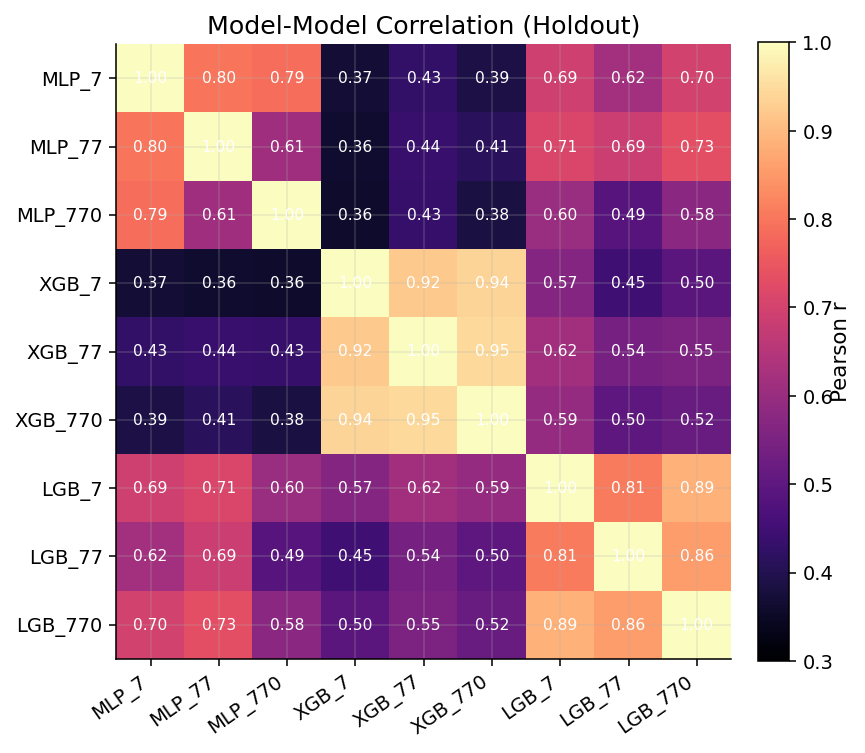

In [6]:
if P is not None and len(names) > 1:
    C = np.corrcoef(P, rowvar=False)  # k x k
    fig, ax = plt.subplots(figsize=(6.2, 5.6))
    im = ax.imshow(C, vmin=0.3, vmax=1.0, cmap="magma")
    ax.set_title("Model-Model Correlation (Holdout)")
    ax.set_xticks(range(len(names))); ax.set_xticklabels(names, rotation=35, ha="right")
    ax.set_yticks(range(len(names))); ax.set_yticklabels(names)
    # 在格子里标数值（简洁）
    for i in range(len(names)):
        for j in range(len(names)):
            ax.text(j, i, f"{C[i,j]:.2f}", ha="center", va="center", color="w", fontsize=8)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Pearson r", rotation=90, va="center")
    tight(); plt.show()
else:
    print("[WARN] skip heatmap (no P).")


Models with lower pairwise correlation (darker cells) contribute greater “diversity” and are therefore better suited to ensembling. Ideally, pronounced block structure across model (MLP, XGB, LGB) is desirable.


Cell 7 — Holdout Daily IC Distribution (Model-by-Box Line)

C:\Users\13004\AppData\Local\Temp\ipykernel_50368\650400753.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, vert=True, patch_artist=True,


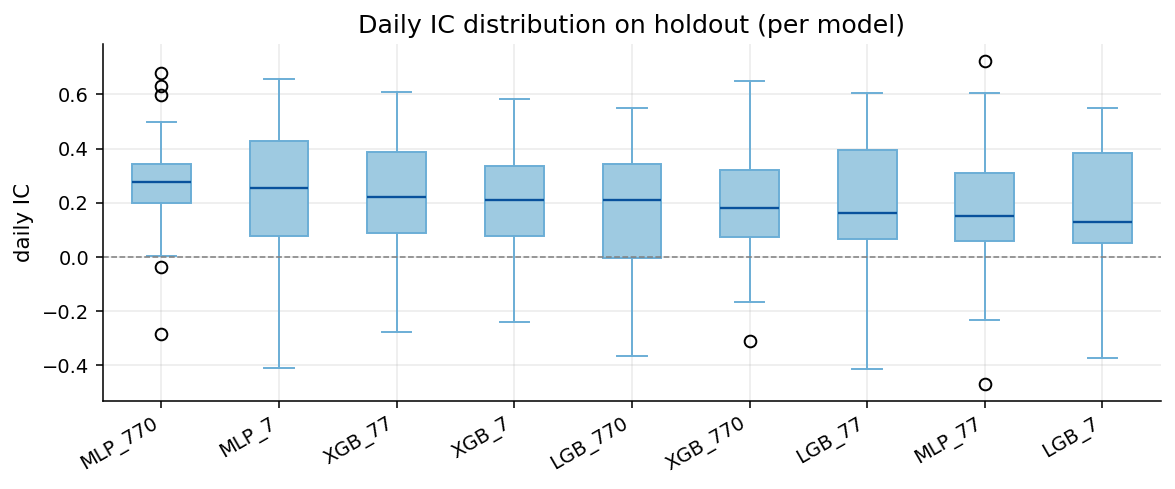

In [7]:
if ic_all is not None and not ic_all.empty:
    # Sort by median from highest to lowest
    order = (ic_all.groupby("model")["ic"].median().sort_values(ascending=False)).index.tolist()
    data = [ic_all.loc[ic_all["model"]==m, "ic"].values for m in order]
    plt.figure(figsize=(8.5,3.6))
    bp = plt.boxplot(data, labels=order, vert=True, patch_artist=True,
                     boxprops=dict(facecolor="#9ecae1", edgecolor="#6baed6"),
                     medianprops=dict(color="#08519c", linewidth=1.2),
                     whiskerprops=dict(color="#6baed6"),
                     capprops=dict(color="#6baed6"))
    plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
    plt.title("Daily IC distribution on holdout (per model)")
    plt.ylabel("daily IC")
    plt.xticks(rotation=30, ha="right")
    tight(); plt.show()
else:
    print("[WARN] no ic_all; skip boxplot.")

Boxplots foreground robustness: a narrower interquartile range indicates greater stability, and a higher location (e.g., median) is preferable. This makes it straightforward to identify which model class is more stable.


Cell 8 — Holdout IC Time Series (eq / grid / ridge-clip overlay, 5-day moving average)

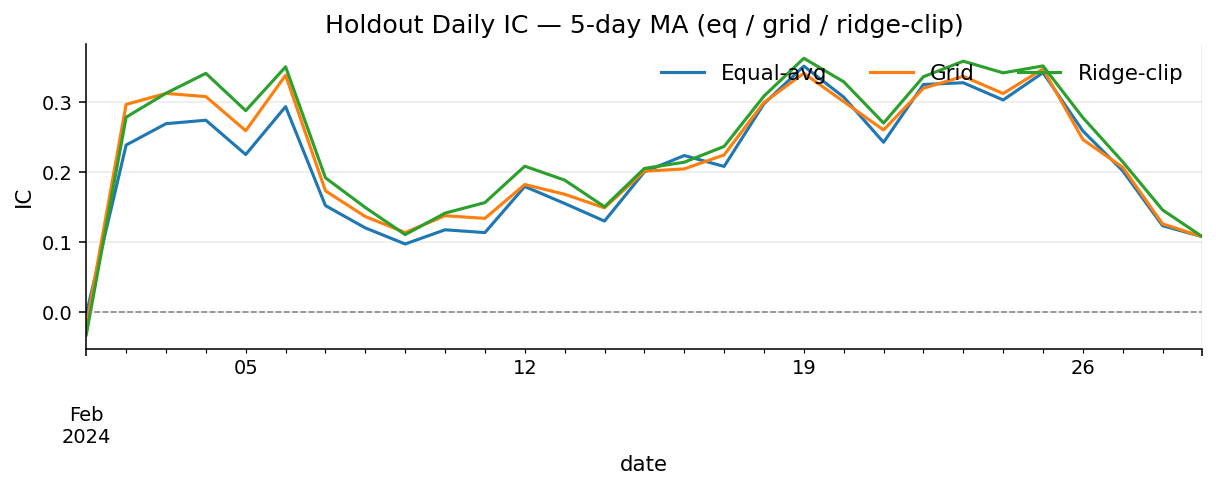

In [8]:
def ensemble_series_from_ic(ic_all, ordered_names, weights=None):
    pivot = ic_all.pivot_table(index="date", columns="model", values="ic", aggfunc="mean")
    pivot = pivot[[n for n in ordered_names if n in pivot.columns]]  # 对齐列顺序
    if weights is None:
        s = pivot.mean(axis=1)
    else:
        w = np.asarray(weights, float)
        w = w / (np.abs(w).sum() + 1e-12)  # 为了可比显示，做尺度规整
        s = (pivot * w).sum(axis=1)
    return s.sort_index()

if ic_all is not None and not ic_all.empty:
    ordered = list(VALPREDS.keys())  # 与权重向量一致
    s_eq    = ensemble_series_from_ic(ic_all, ordered, None)
    s_grid  = ensemble_series_from_ic(ic_all, ordered, W_GRID)
    s_rclip = ensemble_series_from_ic(ic_all, ordered, W_RIDGE_CLIP)

    plt.figure(figsize=(9.0, 3.6))
    s_eq.rolling(5, min_periods=1).mean().plot(label="Equal-avg", linewidth=1.6)
    s_grid.rolling(5, min_periods=1).mean().plot(label="Grid", linewidth=1.6)
    s_rclip.rolling(5, min_periods=1).mean().plot(label="Ridge-clip", linewidth=1.6)
    plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
    plt.legend(ncol=3, frameon=False, loc="upper right")
    plt.title("Holdout Daily IC — 5-day MA (eq / grid / ridge-clip)")
    plt.ylabel("IC")
    tight(); plt.show()
else:
    print("[WARN] no ic_all; skip IC timeseries.")


A single figure plots the time-varying performance of three ensembles, enabling a direct assessment of whether ridge-clip’s advantage remains stable across most periods.